# Gibbs sampling on random multivariate Gaussians.

In [ ]:
import sys
from copy import copy
import itertools as it, functools as ft
from collections import OrderedDict as ordict, defaultdict as ddict
import numpy as np
import scipy.stats as scs
from scipy.interpolate import griddata

In [68]:
class Gaussian(object):
    def __init__(self, mean=None, covariance=None, eigenvectors=None, eigenvalues=None, ndim=None):
        if covariance is None:
            if eigenvectors is None or eigenvalues is None:
                raise ValueError()
        else:
            if eigenvectors is not None or eigenvalues is not None:
                raise ValueError()
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
        if ndim is None:
            ndim = len(mean) if mean is not None else len(eigenvalues)
        self.mean = np.zeros((ndim,)) if mean is None else np.array(mean, dtype=float)
        self.eigenvalues = np.ones((ndim,)) if eigenvalues is None else np.array(eigenvalues, dtype=float)
        self.eigenvectors = np.identity(ndim) if eigenvectors is None else np.array(eigenvectors, dtype=float)
        assert self.mean.shape == (ndim,)
        assert self.eigenvalues.shape == (ndim,)
        assert self.eigenvectors.shape == (ndim, ndim)
        if not (self.eigenvalues > 0).all():
            raise ValueError("covariance must be positive definite")

    @property
    def ndim(self):
        return len(self.mean)

    @property
    def covariance(self):
        return np.einsum("ij,j,jk->ik", self.eigenvectors, self.eigenvalues,
                         self.eigenvectors.T, optimize=True)

    def distance(self, x):
        return np.einsum("...i,ij,j,jk,...k->...",
                         x - self.mean, self.eigenvectors,
                         1 / self.eigenvalues,
                         self.eigenvectors.T, x - self.mean,
                         optimize=True)

    def pdf(self, x):
        return (np.exp(-0.5 * self.distance(x))
                / np.sqrt(np.prod(2 * np.pi * self.eigenvalues)))

    def projection(self, proj):
        projected_mean = np.dot(proj, self.mean)
        projected_covariance = np.einsum("ij,jk,k,kl,lm->im", proj, self.eigenvectors, self.eigenvalues, self.eigenvectors.T, proj.T)
        return Gaussian(mean=projected_mean, covariance=projected_covariance)

    def conditional(self, value, cond, pred):
        # [x, y]T ~ N([a, b]T, [[A, C], [CT, B]])
        # => x|y ~ N(a + C B-1 (y-b), A - C B-1 CT)

        pred_covar  = np.dot(pred, np.dot(self.covariance, pred.T))
        cond_covar  = np.dot(cond, np.dot(self.covariance, cond.T))
        cross_covar = np.dot(pred, np.dot(self.covariance, cond.T))

        pred_mean = np.dot(pred, self.mean)
        cond_mean = np.dot(cond, self.mean)
        cond_value = np.dot(cond, value)

        #print "c", cond.shape, "p", pred.shape
        #print "cx", cond_covar.shape, "px", pred_covar.shape, "xx", cross_covar.shape
        #print "cm", cond_mean.shape, "pm", pred_mean.shape

        mean = pred_mean + np.dot(cross_covar,
                                  np.linalg.solve(cond_covar,
                                                  cond_value - cond_mean))
        covariance = pred_covar - np.dot(cross_covar,
                                         np.linalg.solve(cond_covar,
                                                         cross_covar.T))
        return Gaussian(mean=mean, covariance=covariance)

    def sample(self):
        return self.mean + np.dot(self.covariance, np.random.randn(self.ndim))

In [3]:
def normalize(v, axis=None):
    return v / np.sqrt((v ** 2).sum(axis=axis, keepdims=True))

def get_canonical_basis(ndim):
    return np.eye(ndim)

def get_random_orthogonal_basis(ndim):
    x = np.random.random((ndim, ndim))
    u, s, v = np.linalg.svd(x)
    return u

def get_unaligned_basis(ndim=2):
    # choice of directions only works in R^(2^m) for integer m
    assert np.log2(ndim) == round(np.log2(ndim))

    if ndim == 1:
        return np.array([[1]], dtype=float)

    assert ndim % 2 == 0
    subvs = get_unaligned_basis(ndim // 2)
    vs = np.concatenate([np.concatenate([ subvs, subvs], axis=1),
                         np.concatenate([-subvs, subvs], axis=1)], axis=0)
    vs /= np.sqrt(2)
    return vs

def get_orthogonal_models(ndim=8):
    vs = get_unaligned_basis(ndim=ndim)
    np.testing.assert_allclose(np.dot(vs, vs.T), np.eye(vs.shape[0]), atol=1e-10)
    models = [Gaussian(eigenvectors=vs,
                       eigenvalues=normalize((np.arange(ndim) == d)*10 + 0.1))
              for d in range(ndim)]
    return models


# Gibbs sampling

In [35]:
def IndependentPicker(directions_picker, model_picker):
    def _call():
        return np.asarray(directions_picker()), model_picker()
    return _call

def RandomElementPicker(xs):
    def _call():
        return xs[np.random.choice(len(xs))]
    return _call

def RandomSubsetPicker(xs, k=None):
    if k is None:
        def _call():
            return [x for x in xs if np.random.random() < 0.5]
    else:
        assert 0 <= k and k <= len(xs)
        def _call():
            return [xs[i] for i in np.random.choice(len(xs), size=k, replace=False)]
    return _call

def RandomDirectionPicker(ndim):
    def _call():
        return normalize(np.random.random((1, ndim,)), axis=1)
    return _call

def ScanPicker(xs):
    i = [-1]
    def _call():
        i[0] += 1
        i[0] %= len(xs)
        return np.array([xs[i[0]]])
    return _call

def run_gibbs(models, picker, nsamples=5000, nburnin=1000):
    niters = nsamples + nburnin
    ndim = models[0].ndim
    directions, model = picker()
    print directions, model
    samples = [model.sample()]
    samples = [np.zeros(ndim) + 3]
    for i in range(niters):
        if i % 100 == 0:
            print i, samples[-1]

        # find directions to condition on and a model from which to sample
        cond, model = picker()

        # find a basis for the other directions
        predTpred = np.eye(ndim) - np.dot(cond.T, cond)
        val, vec = np.linalg.eigh(predTpred)
        pred = np.einsum("i,ij->ij", np.sqrt(val), vec.T)[~np.isclose(val, 0)]
        assert pred.shape == (ndim - len(cond), ndim)

        np.testing.assert_allclose(np.dot(cond.T, cond) +
                                   np.dot(pred.T, pred),
                                   np.eye(ndim))

        cond_sample = samples[-1]
        pred_sample = model.conditional(samples[-1],
                                        cond=cond,
                                        pred=pred).sample()
        sample = (np.dot(cond.T, np.dot(cond, samples[-1])) +
                  np.dot(pred.T, pred_sample))
        samples.append(sample)
    samples = samples[nburnin:]
    samples = np.asarray(samples)
    return samples

def run_mixture(models, nsamples=5000):
    ndim = models[0].ndim
    samples = []
    for i in range(nsamples):
        model = models[np.random.choice(len(models))]
        samples.append(model.sample())
    samples = np.asarray(samples)
    return samples


# Plotting functions.

In [49]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

def get_mesh_bounds(models, num_sigma=3):
    maxev = np.max([model.eigenvalues for model in models])
    return np.sqrt(maxev) * num_sigma

def get_mesh_xy_and_positions(models, res=.01, num_sigma=3, plot_bounds=None):
    if plot_bounds is not None:
        mesh_lb, mesh_ub = plot_bounds
    else:
        mesh_ub = get_mesh_bounds(models, num_sigma=num_sigma) + res
        mesh_lb = - mesh_ub 
    x, y = np.mgrid[mesh_lb:mesh_ub:res, mesh_lb:mesh_ub:res]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    return x, y, pos

def plot_samples(ax, samples, alpha=0.01, s=2, plot_bounds=(-1, 1), 
                 title_str=None):
    #ax.autoscale(False) # To avoid that the scatter changes limits
    samples = np.asarray(samples)
    ax.scatter(samples[:, 0], samples[:, 1], s=s, zorder=1, alpha=alpha)
    ax.set_aspect('equal')
    if title_str is not None:
        ax.set_title(title_str, fontsize='xx-small')
    ax.tick_params(labelsize='xx-small')
    ax.set_xbound(plot_bounds[0], plot_bounds[1])
    ax.set_ybound(plot_bounds[0], plot_bounds[1])
    return ax, plot_bounds

def plot_contours2d(models, ax=None, alpha=0.3, plot_bounds=None):
    assert all(model.ndim == 2 for model in models)

    if ax is None:
        fig = plt.figure()
        ax = plt.gca()

    x, y, pos = get_mesh_xy_and_positions(models, plot_bounds=plot_bounds)

    levels = [0.9]# + list(np.arange(0.2, 1.2, 0.1))
    for i, model in enumerate(models):
        pdf = model.pdf(pos)
        color = plt.cm.rainbow(i * 1. / len(models))
        ax.contour(x, y, pdf, levels, colors=[color], alpha=.1, label='model %d' % i)
        ax.hold(True)
        ax.set_title(str(i))
    ax.set_aspect('equal')#, 'datalim')
    ax.tick_params(labelsize='xx-small')
    #ax.set_xbound(bounds[0], bounds[1])
    #ax.set_ybound(bounds[0], bounds[1])
    #ax.legend()
    #plt.colorbar(ax)
    bounds = [np.min(x), np.max(x)]
    return ax, bounds

def plot_projected(ax, basis, models=(), samples=()):
    if len(models) > 0:
        plot_contours2d([model.projection(basis) for model in models], ax=ax)
    if len(samples) > 0:
        plot_samples(ax, np.dot(samples, basis.T))

def squarish_subplots(k, subplot_size=None):
    m = int(np.round(np.sqrt(k)))
    n = int(np.ceil(k / m))
    if subplot_size is None:
        figsize = None
    else:
        figsize = (n * subplot_size, m * subplot_size)
    fig, axes = plt.subplots(m, n, figsize=figsize)
    if n == 1 or m == 1:
        axes = [axes]
    return fig, axes

def plot_random_projections(models=(), samples=(), nproj=6):
    models = list(models)
    samples = np.asarray(samples)

    assert models
    ndim = models[0].ndim

    fig, axes = squarish_subplots(nproj, subplot_size=8)
    for _, ax in zip(range(nproj), axes.flatten()):
        basis = get_random_orthogonal_basis(ndim=ndim)[:2]
        plot_projected(ax, basis, models=models, samples=samples)
    plt.tight_layout()
    plt.show()

def plot_canonical_projections(models=(), samples=()):
    models = list(models)
    samples = np.asarray(samples)

    assert models
    ndim = models[0].ndim

    directions = np.eye(ndim)
    npairs = ndim * (ndim - 1) // 2

    fig, axes = squarish_subplots(npairs, subplot_size=8)
    for (i, j), ax in zip(it.combinations(range(ndim, 2), np.ravel(axes))):
        basis = np.array([vs[i], vs[j]])
        plot_projected(ax, basis, models=models, samples=samples)
        ax.set_title("%i vs %i" % (i, j))
    plt.tight_layout()
    plt.show()

# Actually doing stuff

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]] <__main__.Gaussian object at 0x7f1c6ec1b950>
0 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
100 [-0.01387744 -0.02718878 -0.02718255 -0.02342715 -0.03359874 -0.02572833
 -0.03637961 -0.01376067  0.02234549  0.01985859  0.03906857  0.02465012
  0.00028353  0.02576545  0.01257209  0.01363986]
200 [ 0.04666684  0.09553554  0.05414236  0.0859505  -0.05889624 -0.08681643
 -0.06942792 -0.10256329  0.10461493  0.09547446  0.07802651  0.07249347
 -0.0835499  -0.0741859  -0.07407307 -0.06056857]
300 [-0.03307944 -0.02514728 -0.02779845  0.00682111  0.03330544  0.05020057
  0.04381113  0.03747665  0.02340068  0.07986449  0.06368166 -0.02306306
 -0.04362182 -0.05828153 -0.04350599 -0.08252988]
400 [-0.13769046 -0.10478047  0.10548044  0.07500698 -0.100359   -0.08102461
  0.05936177  0.01748669  0.10681753 -0.00810399 -0.01793729 -0.07086004
  0.08984325  0.12449895 -0.01237987 -0.12246633]
500 [ 0.03422906 -0

<IPython.core.display.Javascript object>


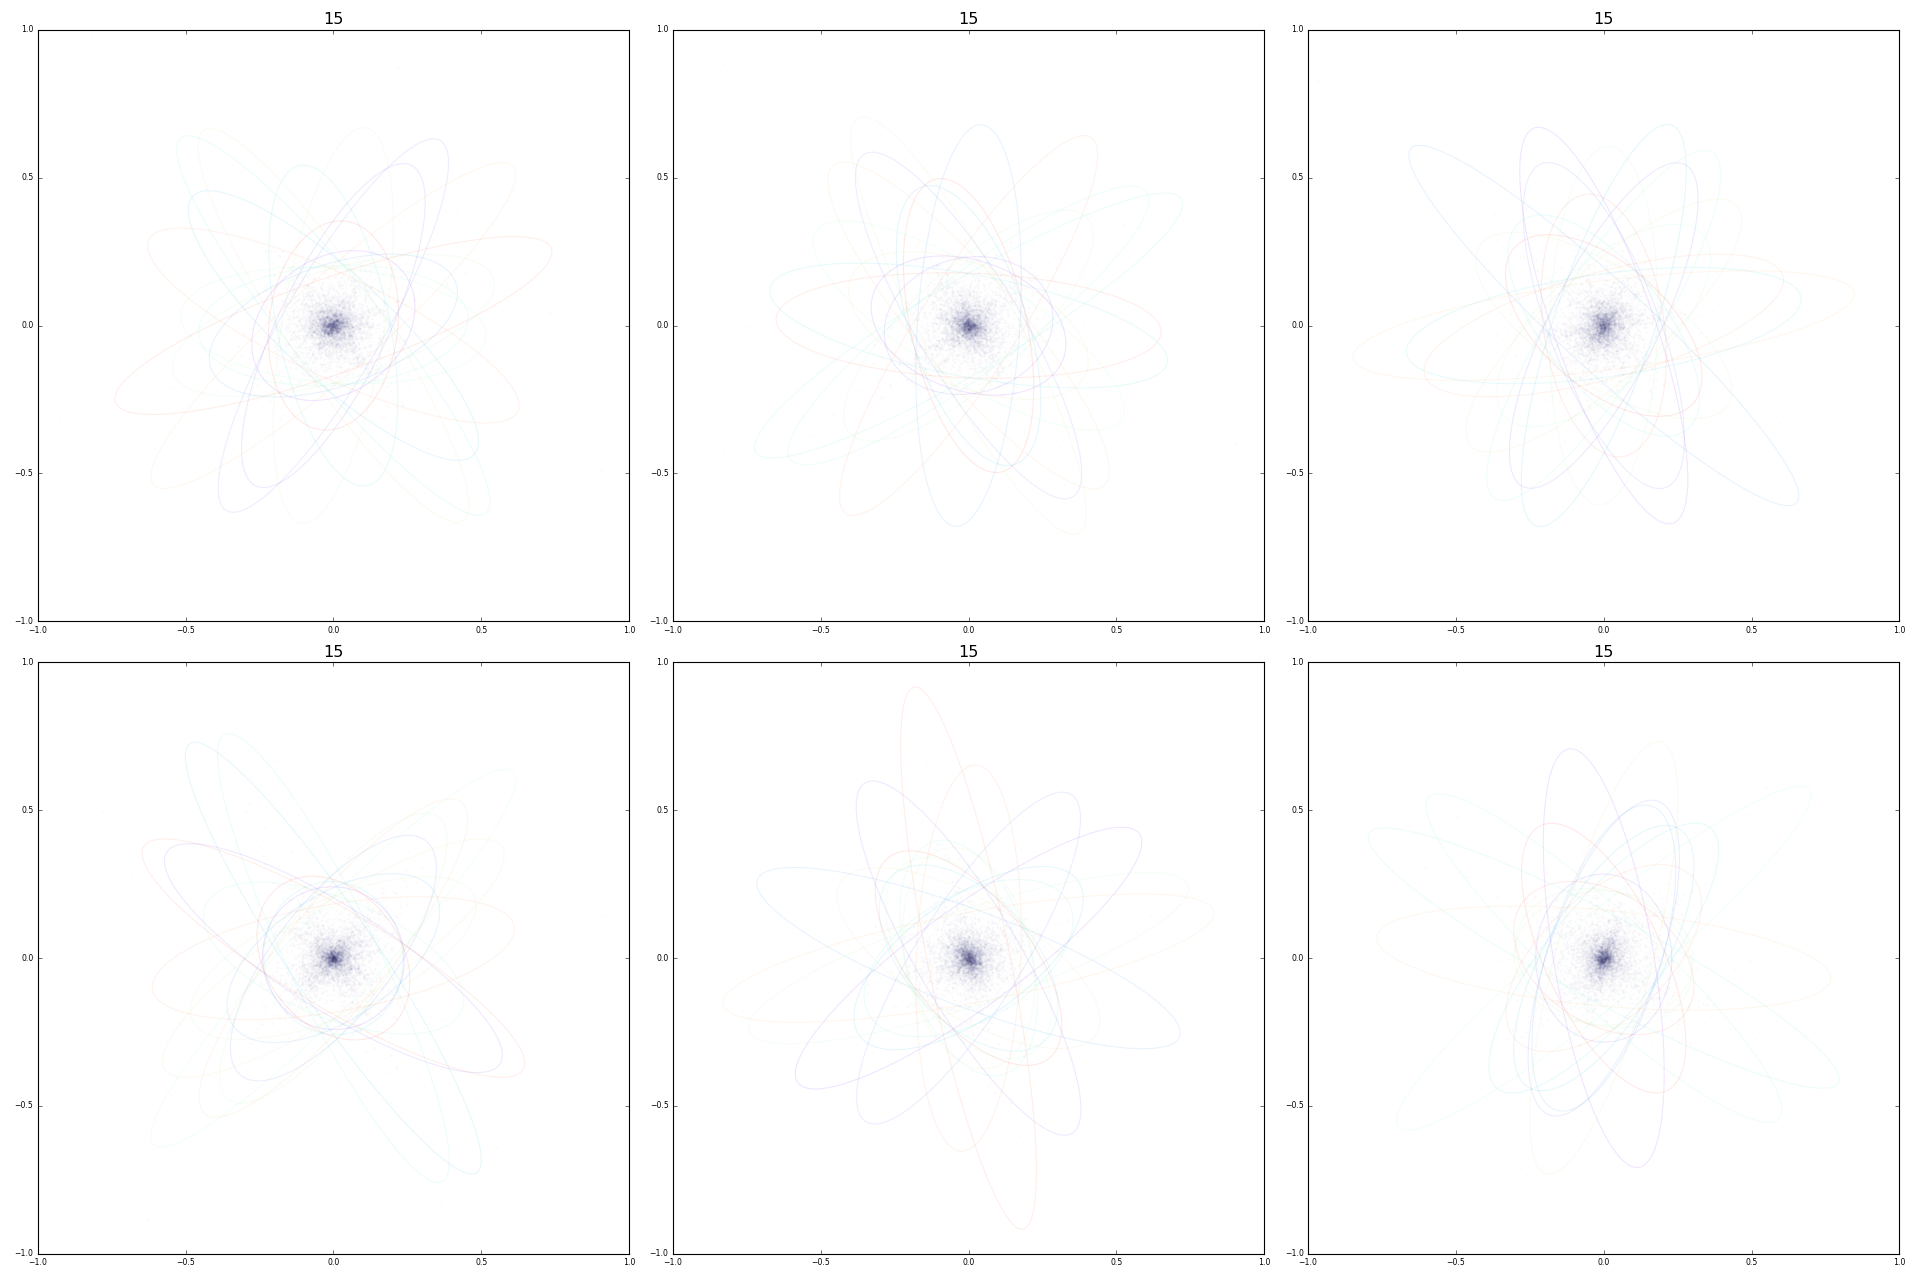

<IPython.core.display.Javascript object>


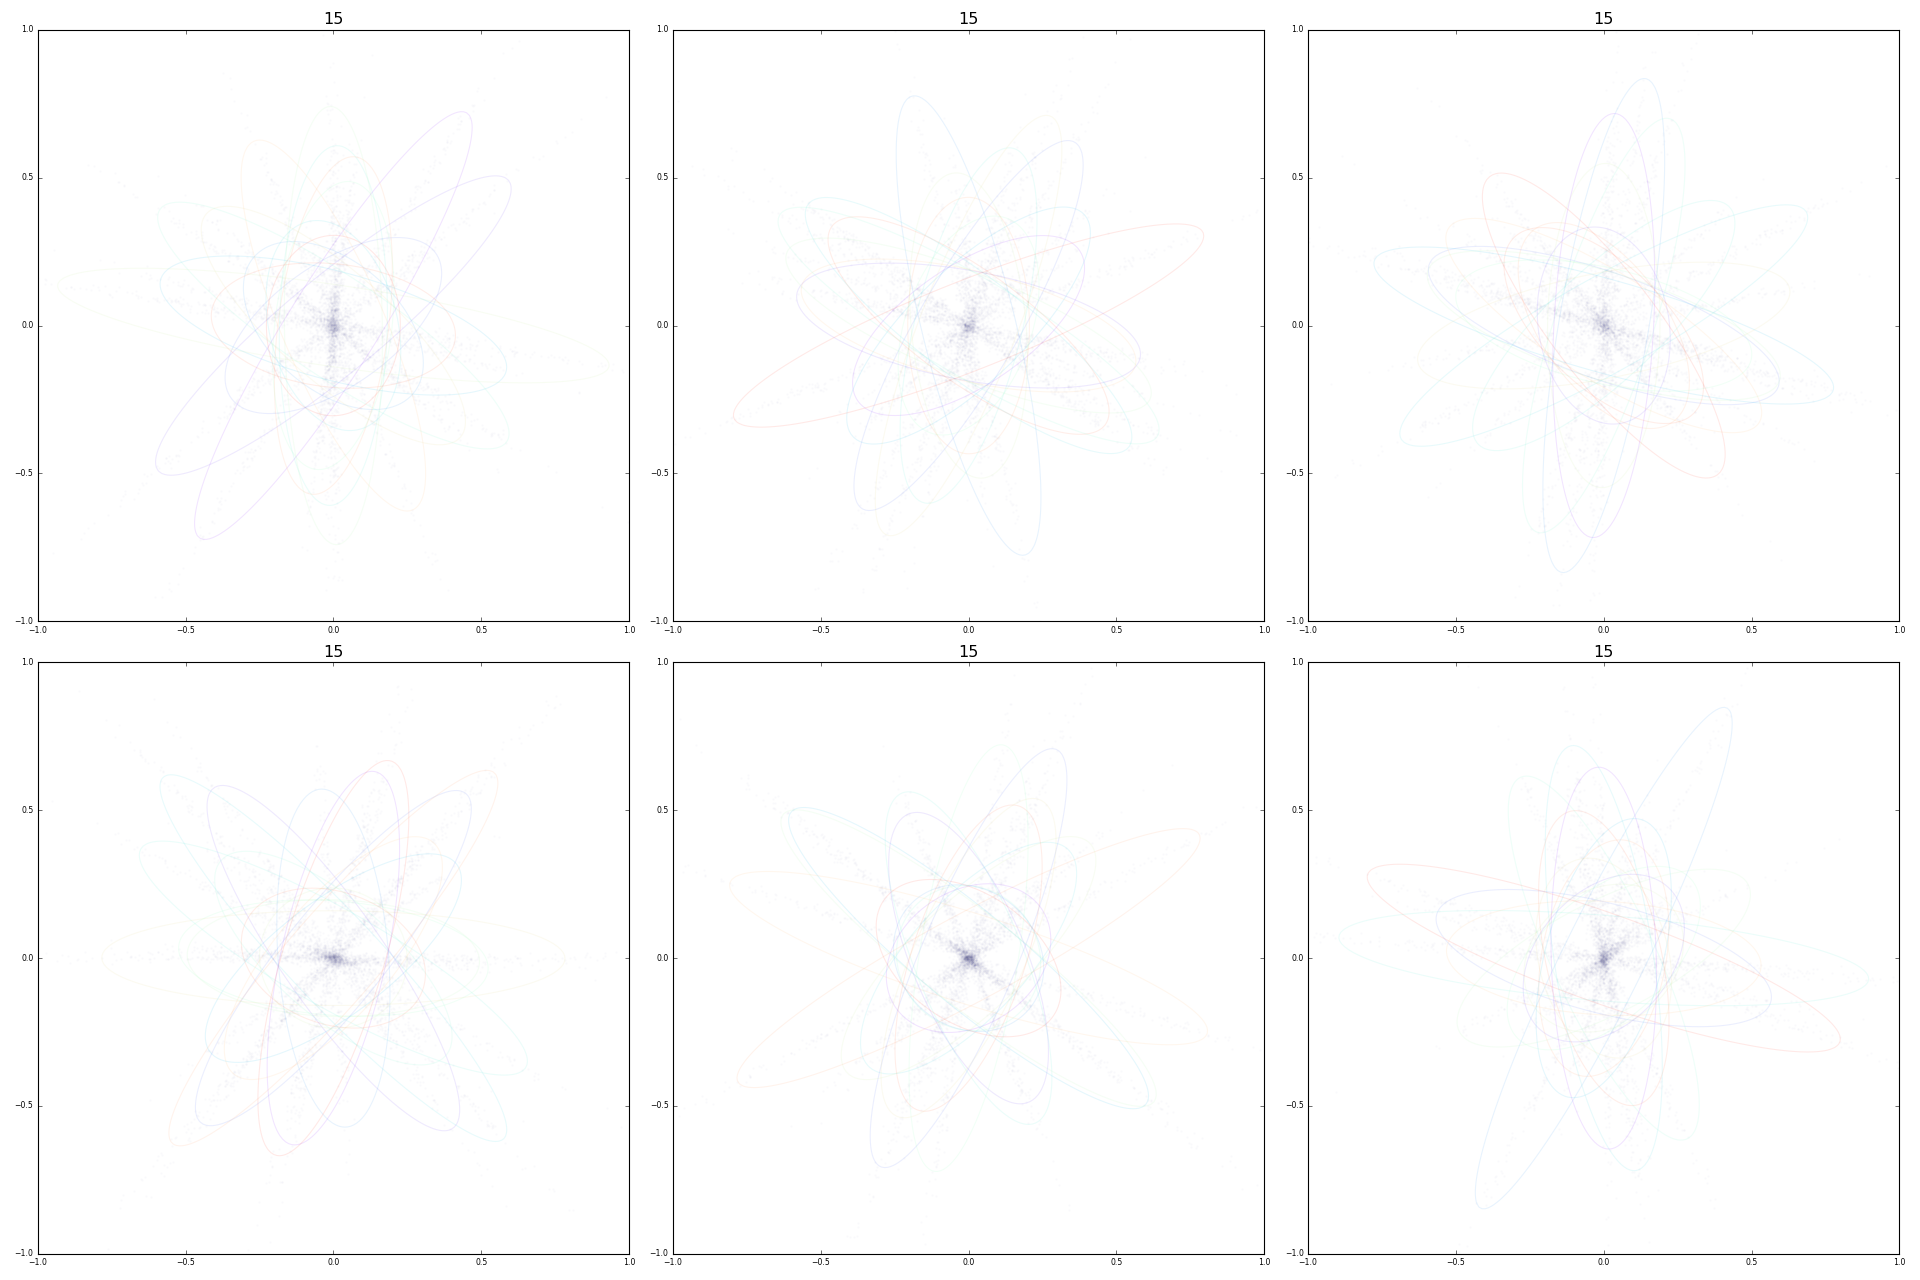

In [50]:
def run_gibbs_job(models, picker, nsamples=5000, nburnin=1000):
    models = list(models)
    samples = run_gibbs(models, picker, nsamples=nsamples, nburnin=nburnin)
    plot_random_projections(models=models, samples=samples)

def run_mixture_job(models, nsamples=5000):
    models = list(models)
    samples = run_mixture(models, nsamples=nsamples)
    plot_random_projections(models=models, samples=samples)

def do_the_thing():
    ndim = 16
    models = get_orthogonal_models(ndim=ndim)
    picker = IndependentPicker(RandomSubsetPicker(get_canonical_basis(ndim=ndim), k=1),
                               RandomElementPicker(models))
    run_gibbs_job(models, picker, nsamples=5000, nburnin=0)
    run_mixture_job(models, nsamples=5000)

do_the_thing()